In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from datetime import timedelta

import numpy as np
import yfinance as yf

from optfolio.optimize import Optimizer

In [4]:
PERIOD = '11y'
TICKERS = [
    # Internet services
    'msft', 'goog', 'fb', 'orcl', 'twtr', 'vmw',
    # Application software
    'adbe', 'crm', 'wday', 'sap', 'shop',
    # Comm. equipment
    'csco',
    # Semiconductors
    'intc', 'amd', 'txn', 'qcom', 'nvda',
    # Misc
    'dell',
    # Personal finance
    'v', 'ma', 'pypl',
    # Consumer directionary
    'aapl', 'nke', 'sne', 'amzn', 'ebay',
    # Aerospace
    'lmt', 'noc',
    # Media
    'nflx', 'dis',
    # Airlines
    'dal', 'ual', 'luv',
    # Automotive
    'tsla'
]

data = yf.download(
    tickers=TICKERS,
    period=PERIOD,
    interval='1d',
    auto_adjust=True,
    prepost=False,
    groupby='ticker'
).dropna(axis=1, how='all')

daily_returns = (data['Close'] / data['Close'].shift(1) - 1)[1:]
daily_returns.head()

[*********************100%***********************]  34 of 34 downloaded


,AAPL,ADBE,AMD,AMZN,CRM,CSCO,DAL,DELL,DIS,EBAY,...,SAP,SHOP,SNE,TSLA,TWTR,TXN,UAL,V,VMW,WDAY
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-13,-0.010889,-0.069865,-0.055556,-0.009052,-0.038911,0.002362,-0.016815,NaN,-0.029756,0.008606,...,0.027425,NaN,-0.037073,NaN,NaN,0.007162,-0.052361,0.003766,-0.048150,NaN
2009-01-14,-0.026606,-0.044796,-0.096639,-0.057532,-0.059379,-0.043205,-0.074447,NaN,-0.019168,-0.085324,...,-0.055055,NaN,0.003500,NaN,NaN,-0.049778,-0.069746,-0.040338,-0.037274,NaN
2009-01-15,-0.023563,-0.013264,0.051163,0.060837,-0.007174,0.004926,0.066304,NaN,0.026801,0.039179,...,0.008828,NaN,0.010962,NaN,NaN,0.031805,0.084713,-0.031281,0.026549,NaN
2009-01-16,-0.012548,0.011042,0.013274,0.002916,0.015896,0.000817,0.041794,NaN,0.004894,-0.012567,...,0.028701,NaN,0.011828,NaN,NaN,0.032638,0.072711,-0.040363,-0.015086,NaN
2009-01-20,-0.049853,-0.079297,-0.126638,-0.061058,-0.072546,-0.051429,-0.034247,NaN,-0.056818,-0.054545,...,-0.064308,NaN,-0.056990,NaN,NaN,-0.040386,-0.027615,-0.105152,-0.078228,NaN


In [5]:
YEAR_BARS = 252
TEST_YEARS = 1
TRAIN_END_DATE = data.index.max() - timedelta(days=TEST_YEARS * 365)
train = daily_returns[(daily_returns.index < TRAIN_END_DATE)].fillna(0)
test = daily_returns[(daily_returns.index >= TRAIN_END_DATE)].fillna(0)
print(np.any(np.isnan(train)))
print(train.shape)
train.head()

False
(2516, 34)


,AAPL,ADBE,AMD,AMZN,CRM,CSCO,DAL,DELL,DIS,EBAY,...,SAP,SHOP,SNE,TSLA,TWTR,TXN,UAL,V,VMW,WDAY
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-13,-0.010889,-0.069865,-0.055556,-0.009052,-0.038911,0.002362,-0.016815,0.0,-0.029756,0.008606,...,0.027425,0.0,-0.037073,0.0,0.0,0.007162,-0.052361,0.003766,-0.048150,0.0
2009-01-14,-0.026606,-0.044796,-0.096639,-0.057532,-0.059379,-0.043205,-0.074447,0.0,-0.019168,-0.085324,...,-0.055055,0.0,0.003500,0.0,0.0,-0.049778,-0.069746,-0.040338,-0.037274,0.0
2009-01-15,-0.023563,-0.013264,0.051163,0.060837,-0.007174,0.004926,0.066304,0.0,0.026801,0.039179,...,0.008828,0.0,0.010962,0.0,0.0,0.031805,0.084713,-0.031281,0.026549,0.0
2009-01-16,-0.012548,0.011042,0.013274,0.002916,0.015896,0.000817,0.041794,0.0,0.004894,-0.012567,...,0.028701,0.0,0.011828,0.0,0.0,0.032638,0.072711,-0.040363,-0.015086,0.0
2009-01-20,-0.049853,-0.079297,-0.126638,-0.061058,-0.072546,-0.051429,-0.034247,0.0,-0.056818,-0.054545,...,-0.064308,0.0,-0.056990,0.0,0.0,-0.040386,-0.027615,-0.105152,-0.078228,0.0


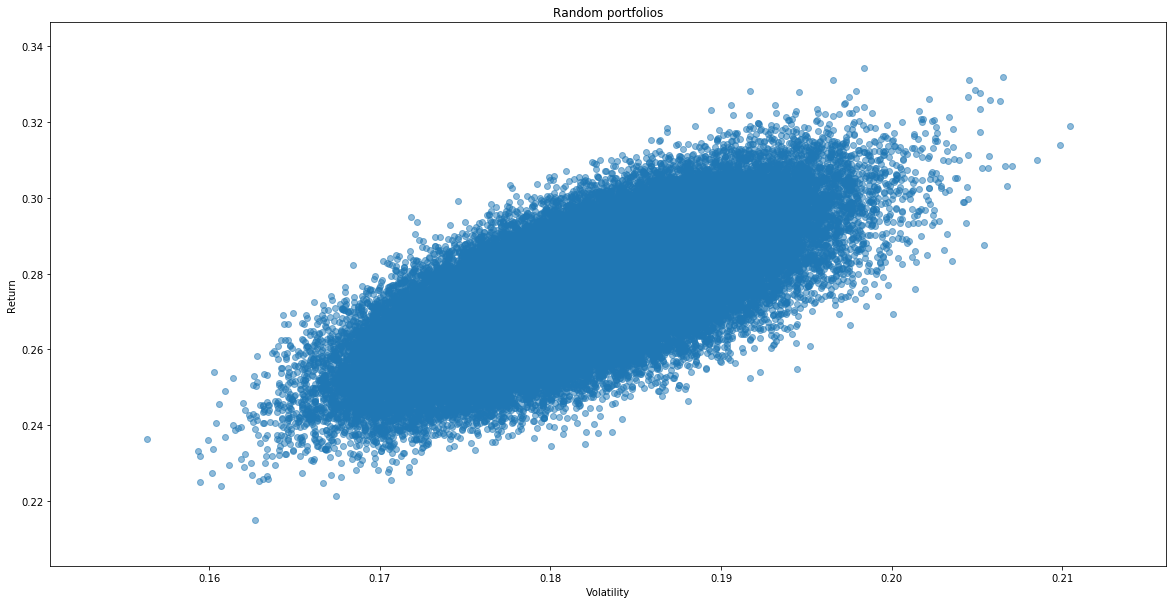

In [6]:
def random_population(n_assets, population_size):
    weights = np.random.uniform(0, 1, size=(population_size, n_assets))

    return weights / weights.sum(axis=-1).reshape((-1, 1))

def annualized_portfolio_return(returns, weights):
    weighted_returns = np.matmul(weights, np.mean(returns.values, 0))

    return (weighted_returns + 1) ** YEAR_BARS - 1


def annualized_portfolio_volatility(returns, weights):
    variance = np.sum(weights * np.matmul(weights, np.cov(returns.T.values)), -1)

    return np.sqrt(variance) * np.sqrt(YEAR_BARS)
    

def annualized_portfolio_performance(returns, weights):
    return np.stack([
        annualized_portfolio_return(returns, weights),
        annualized_portfolio_volatility(returns, weights)
    ], -1)

rand_weights = random_population(train.shape[1], 100000)
rand_solutions = annualized_portfolio_performance(train, rand_weights)

plt.figure(figsize=(20,10))
plt.title('Random portfolios')
plt.scatter(rand_solutions[:,1], rand_solutions[:,0], alpha=.5)
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

In [7]:
optimizer = Optimizer(mutation_sigma=1.0, verbose=False)
solutions, stats = optimizer.run(train.values)

In [8]:
solutions.shape

(85, 34)

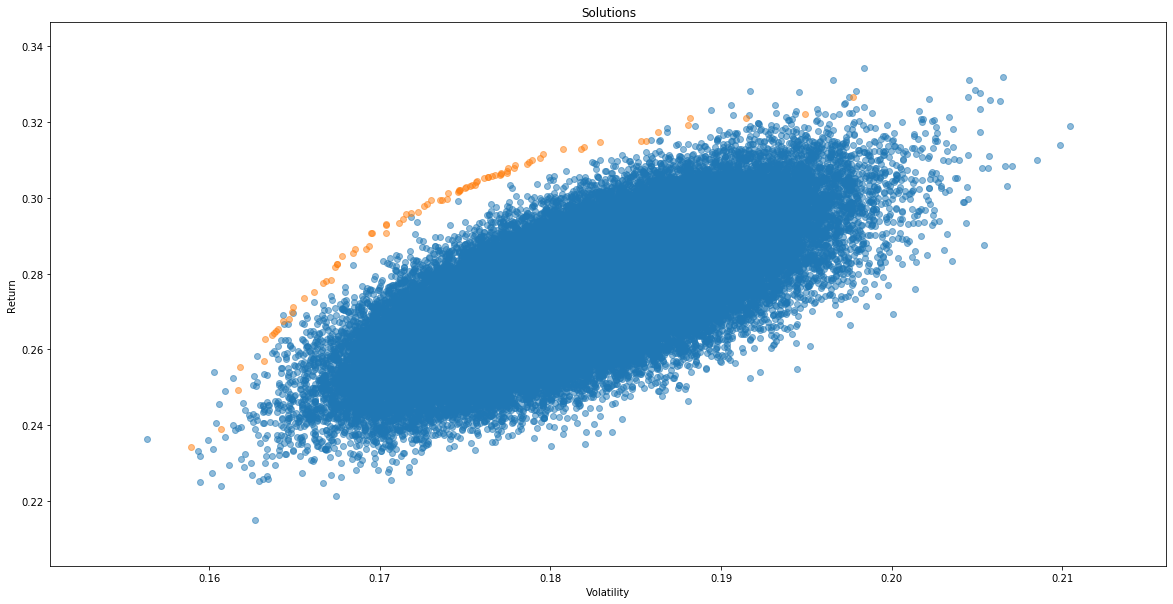

In [9]:
ov = annualized_portfolio_performance(train, solutions)
plt.figure(figsize=(20,10))
plt.title('Solutions')
plt.scatter(rand_solutions[:,1], rand_solutions[:,0], alpha=.5)
plt.scatter(ov[:,1], ov[:,0], alpha=.5)
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

In [10]:
sharpe = ov[:,0] / ov[:,1]
solution = solutions[np.argmax(sharpe)]

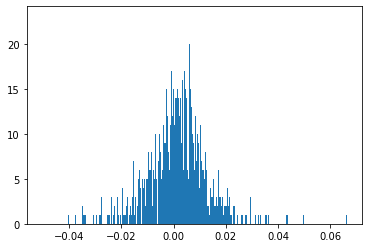

In [11]:
ret = np.dot(train, solution)
plt.hist(ret, bins=1000)
plt.show()

In [30]:
def _normalize_hist(hist, bins):
    return (
        hist / np.sum(hist),
        bins[:-1] + (bins[1:] - bins[:-1]) / 2.0
    )

def plot_traces(traces, hist_bins = 1000):
    QUANTILES = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    cum_returns = np.cumprod(traces + 1, axis=-1) - 1

    plt.figure(figsize=(20,10))
    # 95th symmetric confidence interval
    fq = np.percentile(cum_returns, q=[2.5, 97.5], axis=0)
    plt.fill_between(np.arange(traces.shape[1]), fq[0], fq[1], alpha=.1, color='gray', label='95% CI')
#     fq = np.percentile(cum_returns, q=[0.5, 99.5], axis=0)
#     plt.fill_between(np.arange(traces.shape[1]), fq[0], fq[1], alpha=.1, color='blue', label='99% CI')
    # Quantiles
    for i, v in enumerate(np.quantile(cum_returns, q=QUANTILES, axis=0)):
        plt.plot(v, label='Q: %dth' % int(QUANTILES[i] * 100))
    plt.axhline(0, color='black')
    plt.xlabel('Days')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

    def _return_distributions_plot(cum_returns, period_bars=252, period='year'):
        period_returns = cum_returns[:,(period_bars-1)::period_bars]
        range_end = int(np.ceil(np.percentile(period_returns[:,-1], q=[99.9])))

        plt.figure(figsize=(20,6))
        plt.subplot(1,2,1)
        plt.title('Return density after nth %s' % (period))
        hb = []
        for i in range(period_returns.shape[1]):
            hist, bins = np.histogram(period_returns[:,i], bins=hist_bins, density=True, range=(-1, range_end))
            hist, bins = _normalize_hist(hist, bins)
            plt.bar(bins, hist, width=5000/period_returns.shape[0], alpha=.3, label='%s %d' % (period.title(), i + 1))
            hb.append((hist, bins))
        plt.legend()
        plt.xlabel('Return')
        plt.ylabel('Probability')

        plt.subplot(1,2,2)
        plt.title('Min. return P')
        for i, (hist, bins) in enumerate(hb):
            plt.plot(bins, 1 - np.cumsum(hist), label='%s %d' % (period.title(), i + 1))
        plt.axvline(0, color='black')
        plt.xlabel('Return')
        plt.ylabel('P(Return >= X)')
        plt.legend()
        plt.show()
        
    _return_distributions_plot(cum_returns[:,:252], period_bars=21, period='month')
    _return_distributions_plot(cum_returns, period_bars=252, period='year')

In [12]:
from optfolio.returns_projection import cumulative_n_period_returns, sample_returns, mcmc_sample_returns

In [13]:
traces = sample_returns(ret, 5 * 252, n_traces = 100000)

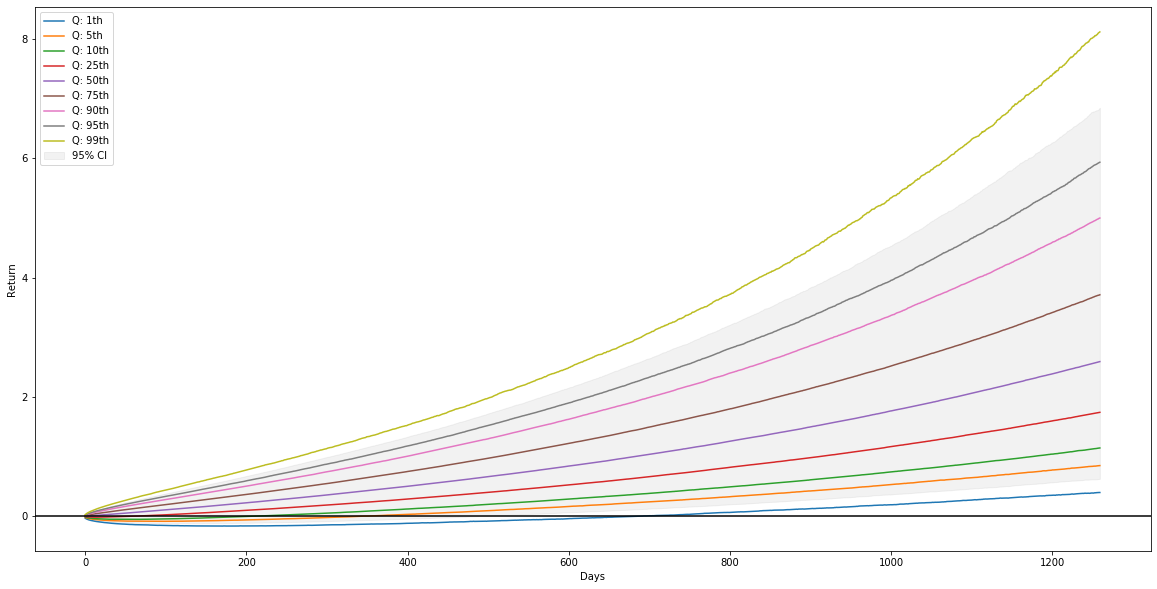

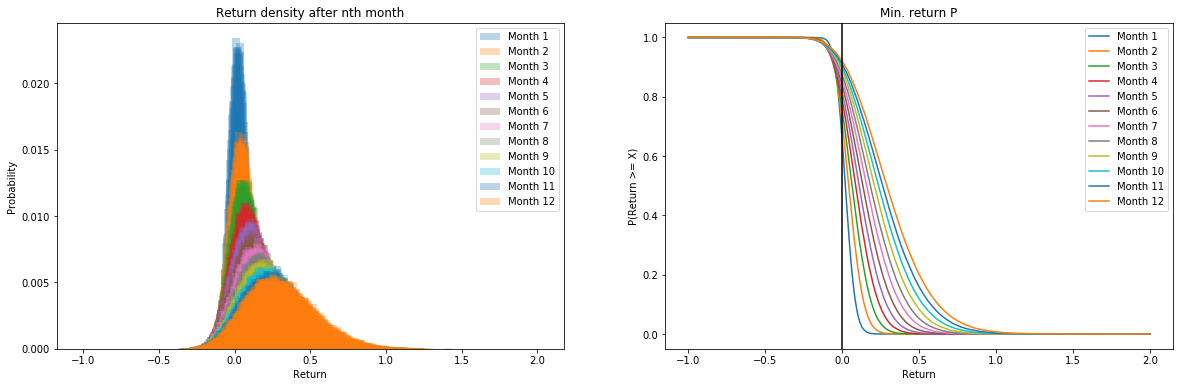

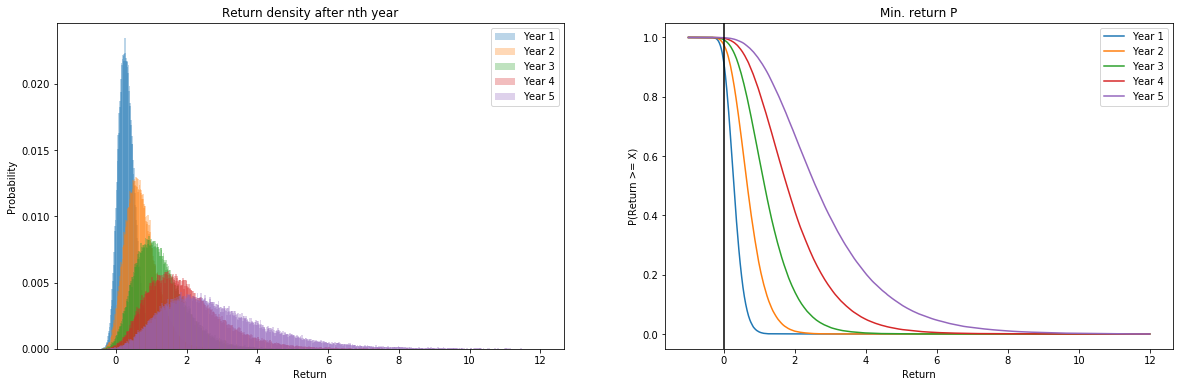

In [31]:
plot_traces(traces)

In [28]:
mcmc_traces = mcmc_sample_returns(ret, 5 * 252, n_traces=10000, mc_states = 15, n_jobs=10)

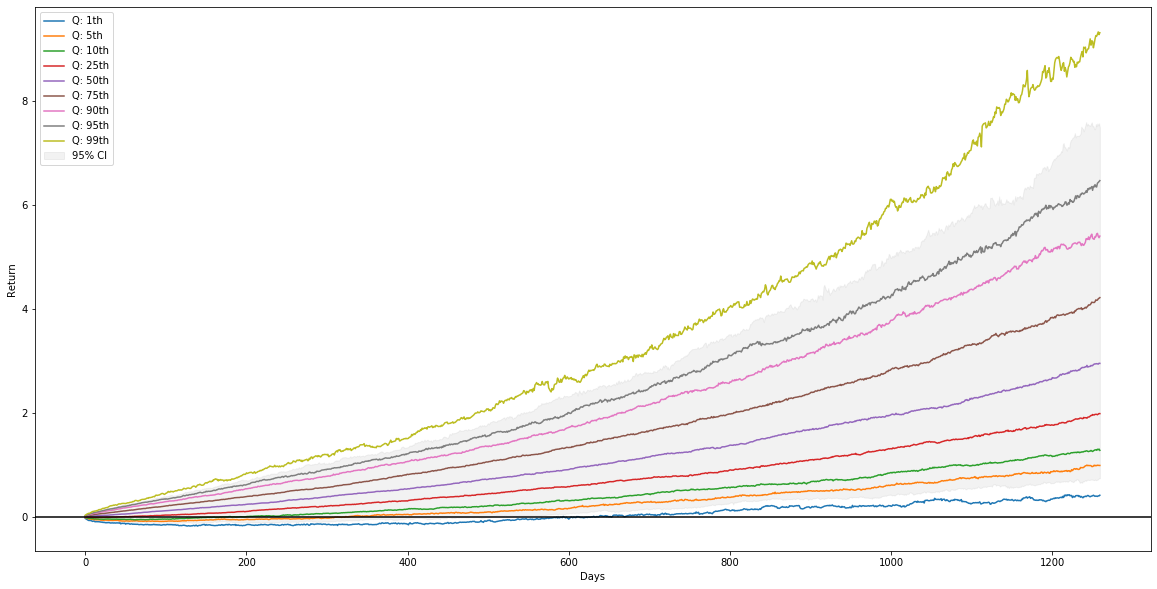

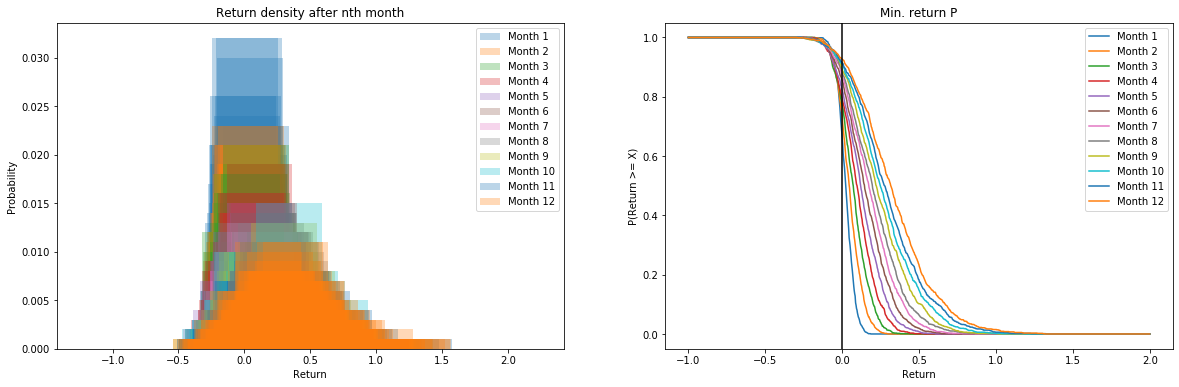

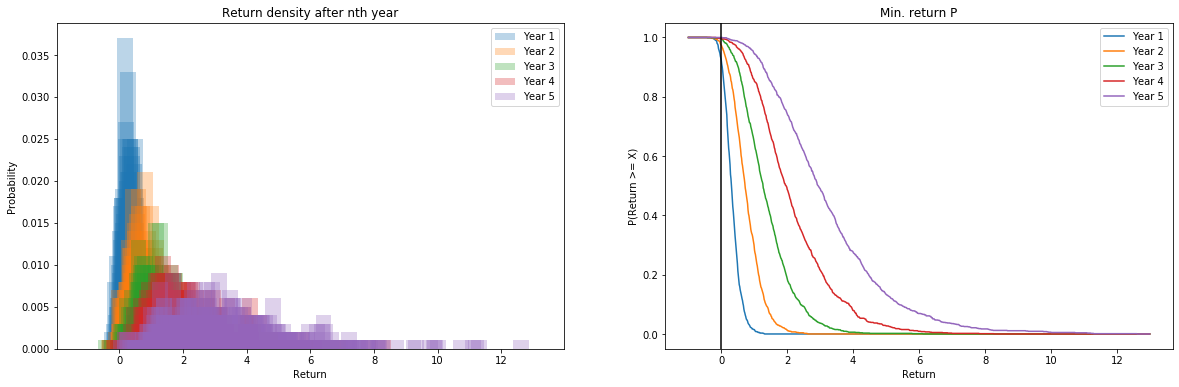

In [32]:
plot_traces(mcmc_traces)